# ISSM "square ice shelf" tutorial (with moving front)

Doesn't work yet.  

## Imports

In [1]:
########################
### "normal" imports ###
########################

import numpy as np
import matplotlib.pyplot as plt
from shapely import LineString
from shapely.geometry import Point, Polygon

######################
### ISSM functions ###
######################

from model import model
from setmask import setmask
from setflowequation import setflowequation
from solve import solve
from plotmodel import plotmodel
from cuffey import cuffey #calculates flow parameter B from temperature
from squaremesh import squaremesh
from verbose import verbose
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

OSGeo/GDAL for Python not installed, overlay plots are not enabled


## Initialize model and mesh domain

In [2]:
md = model()
Lx, Ly = 1e6, 1e6
md = squaremesh(md, Lx, Ly, 150, 40) #squaremesh(model, x, y, nx, ny)
md = setflowequation(md, 'SSA', 'all') #we will apply the SSA over the entire domain

## Describe boundaries and levelsets

ISSM needs to know which parts of the domain are grounded ice, floating ice, terminus boundary, and ocean. Additionally, it will be useful to set up distinct boundary subsets (terminus, sidewalls, and inflow boundary). 

In [3]:
x, y = md.mesh.x, md.mesh.y
x_max, x_min, y_max, y_min = x.max(), x.min(), y.max(), y.min()
x_t = 3/5*Lx #unlike the tutorial, we'll have the shelf terminate before the end of the domain


##########################################
### define the terminus and ice domain ###
##########################################
ys = np.linspace(y_min, y_max, 200)
terminus_curve = LineString([(x_t, y_i) for y_i in ys])

tx, ty = np.array(terminus_curve.coords).T

Ω_ice = Polygon([
    (x_min, y_min),
    (x_min, y_max),
    *zip(tx[::-1], ty[::-1]),   # walk down along the terminus
    (x_min, y_min)
])

##############################
### describe the levelsets ###
##############################

dist = np.array([terminus_curve.distance(Point(xi, yi)) for xi, yi in zip(x, y)]) #distance from the terminus curve (unsigned)
inside = np.array([Ω_ice.covers(Point(xi, yi)) for xi, yi in zip(x, y)]) #T/F values for ice domain, for signing the distance
md.mask.ice_levelset = np.where(inside, -dist, dist) #distance from curve, negative on ice, positive off ice, zero on terminus
md.mask.ocean_levelset = -np.ones_like(x) #ocean exists where md.mask.ocean_levelset < 0 

###############################################
### describe additional boundary components ###
###############################################

Γ_inflow = (x == x_min) #inflow boundary on the leftmost boundary
Γ_sidewalls = (y == y_max) | (y == y_min) #sidewalls on the upper and lower boundaries

## Material parameters and initial configuration

In [4]:
##########################
### material densities ###
##########################

ρ_i = md.materials.rho_ice
ρ_w = md.materials.rho_water
ϱ = ρ_i/ρ_w

########################
### initial geometry ###
########################

H_min = 300
H_max = 1000
H = H_max + (H_min - H_max)*(x - x_min)/(x_t - x_min)
H[md.mask.ice_levelset > 0] = 0
s = (1 - ϱ)*H
b = s - H
md.geometry.thickness = H
md.geometry.base = b
md.geometry.surface = s

######################
### basal friction ###
######################

num_e = md.mesh.numberofelements
md.friction.coefficient = np.zeros(num_e) #these don't really matter
md.friction.p = np.ones(num_e) #since all our ice is floating
md.friction.q = np.ones(num_e) #but they still need to be initialized

################
### rheology ###
################

temp_C = -20
md.materials.rheology_B = cuffey((273 + temp_C)*np.ones_like(x))

## Set boundary conditions

Set velocity boundary conditions in $x$ and $y$ using ```md.stressbalance.spcvx``` and ```md.stressbalance.spcvy```.

/home/mielebzu/ISSM/src/m/plot/plotmodel.py:139: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


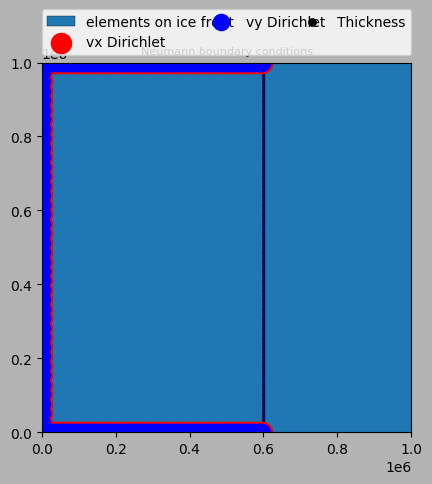

In [5]:
md.stressbalance.spcvx = np.nan*np.ones_like(x) #initialize single-point constraints (SPCs) on vx and vy
md.stressbalance.spcvy = np.nan*np.ones_like(x) #wherever these remain nans, the model assumes an ice front

md.stressbalance.spcvx[Γ_inflow] = 0. 
md.stressbalance.spcvx[Γ_sidewalls & (x < x_t)]= 0.
md.stressbalance.spcvy[Γ_sidewalls & (x < x_t)] = 0.
md.stressbalance.spcvy[Γ_inflow] = 0.

plotmodel(md, 'data', 'BC') #plot the boundary conditions

## Additional specifications

A few extra things we need to set before the model will run... mostly unclear why. 

In [6]:
md.stressbalance.referential = np.nan*np.ones((len(x), 6))
md.stressbalance.loadingforce = np.zeros((len(x), 3))
md.miscellaneous.name = 'name'

## Get the instantaneous solution (no timestepping)

In [7]:
md = solve(md, 'StressBalance')
# plotmodel(md, 'data', md.results.StressbalanceSolution.Vel)

checking model consistency
marshalling file 'name'.bin
uploading input file and queuing script
launching solution sequence on remote cluster

──────────────────────────────────────────────────────────────────────
Ice-sheet and Sea-level System Model (ISSM) version 2026.1
          GitHub: https://github.com/ISSMteam/ISSM/
   Documentation: https://issmteam.github.io/ISSM-Documentation/
──────────────────────────────────────────────────────────────────────
call computational core:
   computing new velocity
write lock file:

   FemModel initialization elapsed time:   0.109445
   Total Core solution elapsed time:       1.42255
   Linear solver elapsed time:             0.762567 (54%)

   Total elapsed time: 0 hrs 0 min 1 sec
loading results from cluster


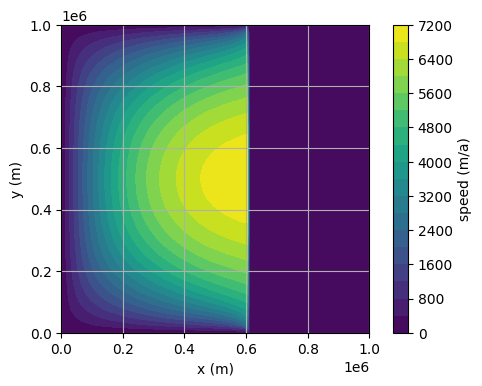

In [8]:
elts = md.mesh.elements - 1
speed_steady = md.results.StressbalanceSolution.Vel.flatten()

plt.figure(figsize = (6, 4))
plt.tricontourf(x, y, elts, speed_steady, levels = 20)
plt.colorbar(label = 'speed (m/a)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().set_aspect('equal')
plt.grid()
plt.show()

## Choose parameters for transient solution

Do this for a non-moving front (i.e., we assume that the advance rate is exactly counteracted by some form of frontal ablation). 

In [9]:
md.timestepping.time_step = 1
md.timestepping.final_time = 1
# md.settings.output_frequency = 10

md.transient.isstressbalance = 1 #solve the stress balance: yes
md.transient.ismasstransport = 1 #solve mass transport: yes
md.transient.isthermal = 0 #don't bother with heat transport

md.smb.initialize(md) #initialize an empty SMB field
md.basalforcings.initialize(md) #something something basal forcing?

md.masstransport.spcthickness = np.nan*np.ones_like(x) #initialize thickness boundary conditions as nans
# md.masstransport.spcthickness[Γ_inflow] = H_max #set this so that the thickness inflow condition preserves the upstream thickness

md.initialization.vx = md.results.StressbalanceSolution.Vx.copy() #borrow initialization velocities from the instantaneous solution
md.initialization.vy = md.results.StressbalanceSolution.Vy.copy()              

      no smb.mass_balance specified: values set as zero
      no basalforcings.groundedice_melting_rate specified: values set as zero
      no basalforcings.floatingice_melting_rate specified: values set as zero


## And solve

In [10]:
md.verbose = verbose('solution', False, 'module', False) #to prevent output each timestep

model_time = 50
Δt = md.timestepping.final_time
num_timesteps = int(model_time/Δt) + 1

for step in range(num_timesteps):
    
    md = solve(md, 'Transient')

    solution = md.results.TransientSolution[-1]
    u, v = solution.Vx, solution.Vy
    
    xs, ys = terminus_curve.xy
    xs, ys = np.array(xs), np.array(ys)
    x_shift = InterpFromMeshToMesh2d(md.mesh.elements, x, y, u*Δt, xs, ys).flatten()
    y_shift = InterpFromMeshToMesh2d(md.mesh.elements, x, y, v*Δt, xs, ys).flatten()
    xs_new = xs + x_shift
    ys_new = ys # + y_shift
    terminus_curve = LineString(zip(xs_new, ys))
    
    tx, ty = np.array(terminus_curve.coords).T
    
    Ω_ice = Polygon([
        (x_min, y_min),
        (x_min, y_max),
        *zip(tx[::-1], ty[::-1]),   
        (x_min, y_min)
    ])
    
    dist = np.array([terminus_curve.distance(Point(xi, yi)) for xi, yi in zip(x, y)]) 
    inside = np.array([Ω_ice.covers(Point(xi, yi)) for xi, yi in zip(x, y)]) 
    outside = ~inside
    md.mask.ice_levelset = np.where(inside, -dist, dist) 

    md.initialization.vx = solution.Vx.copy()
    md.initialization.vy = solution.Vy.copy()

    md.geometry.thickness[inside] = np.maximum(md.geometry.thickness[inside], H_min)
    md.geometry.surface[inside] = (1 - ϱ)*md.geometry.thickness[inside]
    md.geometry.base[inside] = md.geometry.surface[inside] - md.geometry.thickness[inside]

uploading input file and queuing script
launching solution sequence on remote cluster

──────────────────────────────────────────────────────────────────────
Ice-sheet and Sea-level System Model (ISSM) version 2026.1
          GitHub: https://github.com/ISSMteam/ISSM/
   Documentation: https://issmteam.github.io/ISSM-Documentation/
──────────────────────────────────────────────────────────────────────
call computational core:
write lock file:

   FemModel initialization elapsed time:   0.105656
   Total Core solution elapsed time:       0.141817
   Linear solver elapsed time:             0.0490104 (35%)

   Total elapsed time: 0 hrs 0 min 0 sec
uploading input file and queuing script
launching solution sequence on remote cluster

──────────────────────────────────────────────────────────────────────
Ice-sheet and Sea-level System Model (ISSM) version 2026.1
          GitHub: https://github.com/ISSMteam/ISSM/
   Documentation: https://issmteam.github.io/ISSM-Documentation/
─────────────

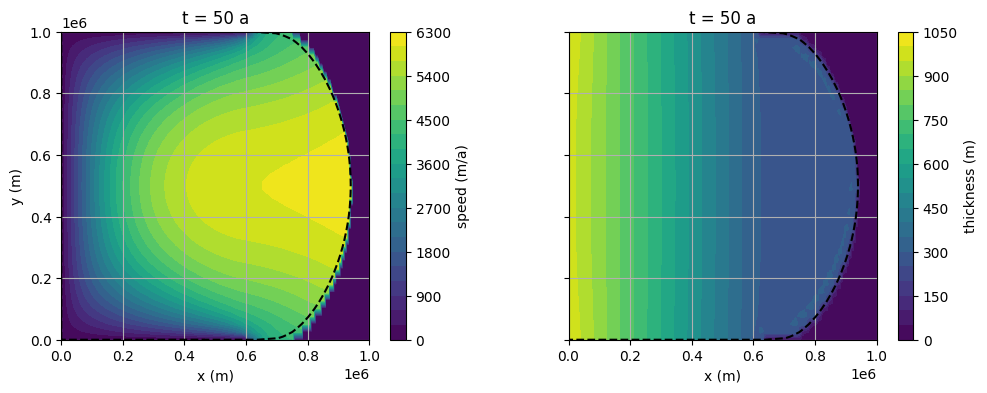

In [11]:
solution = md.results.TransientSolution
step = -1

speed = solution[step].Vel.flatten()
H = solution[step].Thickness.flatten()
px, py = Ω_ice.exterior.xy

fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharex = True, sharey = True)

c0 = ax[0].tricontourf(x, y, elts, speed, levels = 20)
ax[0].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c0, ax = ax[0], label = 'speed (m/a)')
ax[0].set_title(f't = {model_time:g} a')
ax[0].set_xlabel('x (m)')
ax[0].set_ylabel('y (m)')
ax[0].set_aspect('equal')
ax[0].grid()

c1 = ax[1].tricontourf(x, y, elts, H, levels = 20)
ax[1].plot(px, py, color = 'k', linestyle = 'dashed')
fig.colorbar(c1, ax = ax[1], label = 'thickness (m)')
ax[1].set_title(f't = {model_time:g} a')
ax[1].set_xlabel('x (m)')
ax[1].set_aspect('equal')
ax[1].grid()

plt.show()